In [1]:
import numpy as np
#import os

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits

from setup import *

##--------------------------------------------------------------------------##
##             NECESSARY USER INPUTS BELOW....                              ##
##--------------------------------------------------------------------------##

##################
###   WASP4b   ###
##################
#obs_date='ut20150819'                           #observation date
#obj_name='Wasp4'                                #object name   
#midtime=['2015-08-19T07:43:00.00']                 #time of midtransit, WAsp-4b

###################
###   WASP52b   ###
###################
#obs_date='ut20160811'
obs_date='ut20160922'
obj_name='Wasp52'

#midtime=['2016-08-11T04:51:00']               #time of midtransit, Wasp-52b, Transit1
midtime=['2016-09-22T04:44:00']               #time of midtransit, Wasp-52b, Transit2

##################
###   Hats8b   ###
##################
#obs_date='ut20170723'                           #observation date
#obs_date='ut20170828'
#obj_name='Hats8'                                #object name  

#midtime=['2017-07-24T05:28:01.056']                 #time of midtransit, Hats-8b, Transit 1
#midtime=['2017-08-29T01:36:04.608']                 #time of midtransit, Hats-8b Transit 2


path='/Volumes/ermay_ext/Magellan/'+obs_date+'/'
data_path=path+obj_name+'_Spec/'      #path to where your data is saved
flat_path=path+obj_name+'_Flats/'     #path to where your SLIT flats are saved
DARKS=path+obj_name+'_Darks/'     #path to where your darks are saved
FLATS=path+'Full_Flats/'             #path to where the full field flats are saved 
WAVE=path+obj_name+'_Arcs/'

#SAVEPATH='SaveData/'+obj_name+'/'
SAVEPATH=path+'SaveData_'+obj_name+'/'

wavelength_path=path+'WaveSolution/'



extray=400 #number of extra pixels to extract per side in y direction
extrax=80  #number on the side to find wavelength strip, only for nights with a single mask


binn=1    #binning
#### CHECK BINNING IN SETUP.PY ####
#### if 1x1 binning, xpixels,ypixels should be 2048,4096
#### if 2x2 binning, xpixels,ypixels should be 1024,2048
print xpixels/binn, ypixels/binn

2048 4096


In [17]:
print bins
print c1_arr
print c2_arr

[ 4000.  4200.  4400.  4600.  4800.  5000.  5200.  5400.  5600.  5800.
  6000.  6200.  6400.  6600.  6800.  7000.  7200.  7400.  7600.  7800.
  8000.]
[ 0.97748889  0.92798272  0.87847654  0.83605755  0.79600094  0.75594434
  0.71588774  0.67583113  0.64288224  0.61862056  0.59435888  0.5700972
  0.54583551  0.52245946  0.50705405  0.49164865  0.47624324  0.46083784
  0.44543243  0.43002703  0.41462162]
[ 0.97748889  0.92798272  0.87847654  0.83605755  0.79600094  0.75594434
  0.71588774  0.67583113  0.64288224  0.61862056  0.59435888  0.5700972
  0.54583551  0.52245946  0.50705405  0.49164865  0.47624324  0.46083784
  0.44543243  0.43002703  0.41462162]


In [2]:
#####################################################                                                                                           
#####################################################                                                                                           
##        Fitting of lightcurves using BATMAN      ##                                                                                           
##  ---------------------------------------------  ##                                                                                           
##  reads in .npz files from Lightcurve_Script.py  ##                                                                                           
##     See README.txt in Magellan/pipeline         ##                                                                                           
#####################################################                                                                                           
#####################################################   

import spotrod

import numpy as np
np.seterr(all='ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import batman

import emcee
import corner

#import astropy
#from astropy.time import Time
#import pyfits                                                                                                                                  

import scipy
from scipy.interpolate import interp1d

from datetime import datetime
startTime1=datetime.now()

import sys
print (sys.argv)
 

sys.path.insert(0,SAVEPATH) 
from SystemCons import *

print per, rp, sma

rp=0.163

#per=per*24.  #needs to be in hours
#per_e=per_e*24.

pericenter=0.0
k = ecc*np.cos(pericenter)
h = ecc*np.sin(pericenter)
impactparam = sma*np.cos(85.35*np.pi/180.)

#width=200


#################################
t=np.load(SAVEPATH+'Obs_times.npz')['times']
n_exp=len(t)
fulltime=np.load(SAVEPATH+'Obs_times.npz')['times']

####################################################                                                                                            
#              LIMB DARKENING FUNCION              #                                                                                            
####################################################                                                                                            
# U B V R I J H K                                                                                                                               

#limb_dark='quadratic'

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             

q0_func=interp1d(wave,q0)
q1_func=interp1d(wave,q1)

def quadraticlimbdarkening(r, u1, u2):
    answer = np.zeros_like(r)
    mask = (r<=1.0)
    oneminusmu = 1.0 - np.sqrt(1.0 - np.power(r[mask],2))
    answer[mask] = 1.0 - u1 * oneminusmu - u2 * np.power(oneminusmu,2)
    return answer


# Initialize spotrod.
# Number of intergration rings.
n = 1000

# Midpoint rule for integration.
# Integration annulii radii.
r = np.linspace(1.0/(2*n), 1.0-1.0/(2*n), n)
# Weights: 2.0 times limb darkening times width of integration annulii.
#f = 2.0 * quadraticlimbdarkening(r, u1, u2) / n

bins=np.linspace(4000,8000,21)
c1_arr=q0_func(bins)
c2_arr=q1_func(bins)

h=6.626*10**-27   #erg*s
c=3*10**10.   #cm/s2
kb=1.38*10**-16  #erg/K

def Planck(temp,lam):
    return 1.0/(np.exp(h*c/(lam*kb*temp))-1.)


xloc=0.5
spotx=np.array([xloc,xloc])
yloc=0.8
spoty=np.array([-np.sqrt(yloc**2.-spotx[0]**2.),np.sqrt(yloc**2.-spotx[1]**2.)])
spotr=0.1
spotradius=np.array([spotr,spotr])

starT=5000.
spotT=4500.

spotc=Planck(spotT,bins*10**-8.)/Planck(starT,bins*10**-8.)
spotcontrast=np.array([spotc,spotc])


print spotx,spoty,spotradius,spotcontrast

####################################################                                                                                            
#              LIGHT CURVE FUNCTION                #                                                                                            
####################################################     
def lc_func(t0,per,rp,inc,c1,c2,spotx,spoty,spotradius,spotcontrast):
    f=2.0*quadraticlimbdarkening(r,c1,c2)
    t_f=t-t0
    smacm=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=smacm/Rs
    MA=(2*np.pi/per)*t_f
    eta=sma*np.cos(MA)
    xi=sma*np.sin(MA)
    b=sma*np.cos(inc*np.pi/180.)
    planetx=b*eta/sma
    planety=-xi
    z=np.sqrt(planetx**2.+planety**2.)
    planetangle=np.array([spotrod.circleangle(r,rp,z[i]) for i in xrange(z.shape[0])])
    fitlightcurve=spotrod.integratetransit(planetx,planety,z,rp,r,f,spotx,spoty,spotradius,spotcontrast,planetangle)
    params=np.array([planetx,planety,z,rp,r,f])
    return t_f,params,spotx,spoty,spotradius,spotcontrast,fitlightcurve

                                                                                                                          


t0=0


fit_ar=np.empty([len(bins),len(t)])
fit0_ar=np.empty([len(bins),len(t)])

for b in range(0,len(bins)):
    time,params,sx,sy,sr,sc,fit_ar[b,:]=lc_func(t0,per,rp,inc,c1_arr[b],c2_arr[b],spotx,spoty,spotradius,spotcontrast[:,b])

    sx0=np.array([0.0])
    sy0=np.array([0.0])
    sr0=np.array([0.0])
    sc0=np.array([1.0])
    time,params0,sx0,sy0,sr0,sc0,fit0_ar[b,:]=lc_func(t0,per,rp,inc,c1_arr[b],c2_arr[b],sx0,sy0,sr0,sc0)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


['/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/ermay/Library/Jupyter/runtime/kernel-95648d98-11f9-4b45-89a1-96569acbad23.json']
1.7497798 0.15 7.38338832319
[ 0.5  0.5] [-0.6244998  0.6244998] [ 0.1  0.1] [[ 0.44903606  0.46640772  0.48276069  0.49816738  0.51269487  0.52640516
   0.5393554   0.55159829  0.56318234  0.57415224  0.58454921  0.59441123
   0.60377337  0.61266802  0.62112509  0.62917227  0.6368352   0.64413762
   0.65110155  0.65774741  0.66409419]
 [ 0.44903606  0.46640772  0.48276069  0.49816738  0.51269487  0.52640516
   0.5393554   0.55159829  0.56318234  0.57415224  0.58454921  0.59441123
   0.60377337  0.61266802  0.62112509  0.62917227  0.6368352   0.64413762
   0.65110155  0.65774741  0.66409419]]


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:135: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:135: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:136: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:136: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


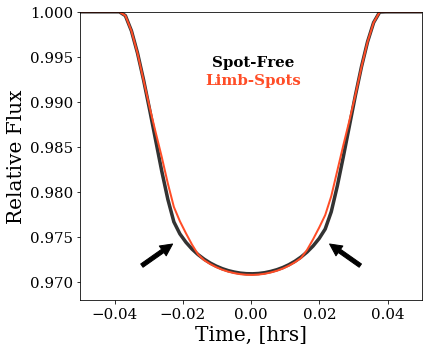

In [39]:
#### PLOTS FOR EACH LAMBA

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

norm=matplotlib.colors.Normalize(vmin=np.min(bins),vmax=np.max(bins))                                                                                                                 
colors=matplotlib.cm.rainbow
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

px=params[0]
py=-1.0*params[1]

sy=-1.0*sy
plt_lims=1.5

star_x=np.linspace(-1,1,1000)
star_y=np.linspace(-1,1,1000)
circle=np.empty([len(star_x),len(star_y)])
limb=np.empty([len(star_x),len(star_y)])

output_file_path='/Users/ermay/Desktop/spot_stuff/plots/'

from matplotlib.font_manager import FontProperties
font0=FontProperties()
font=font0.copy()
font.set_family('serif')

fontb=font.copy()
fontb.set_weight('bold')

###### limb darkening ######
####################################################      


for b in range(18,19):#len(bins)):
    plt.clf()

    
    plt.figure(figsize=(6,5))
    plt.gcf().subplots_adjust(bottom=0.15,top=0.95,left=0.2,right=0.99)
    
    plt.plot(time,fit_ar[b,:],linewidth=2.0,color=scal_m.to_rgba(bins[b]),zorder=2)
    plt.plot(time,fit0_ar[b,:],linewidth=3.5,color='black',zorder=1,alpha=0.8)
    plt.ylim(0.968,1.0)
    plt.xlim(-0.05,0.05)
    
    plt.xticks(fontsize=15,fontproperties=font)
    plt.yticks(fontsize=15,fontproperties=font)
    #ax[0].set_yticklabels(fontsize=15,fontproperties=font)
    
    plt.xlabel('Time, [hrs]',fontsize=20,fontproperties=font)
    plt.ylabel('Relative Flux',fontsize=20,fontproperties=font)
    
    plt.figtext(0.6,0.8,'Spot-Free',color='black',fontsize=15,fontproperties=fontb,ha='center')
    plt.figtext(0.6,0.75,'Limb-Spots',color=scal_m.to_rgba(bins[b]),fontsize=15,fontproperties=fontb,ha='center')
    
    plt.annotate('',xytext=(-0.035,0.971),xy=(-0.02,0.975),arrowprops=dict(facecolor='black',shrink=0.2))
    plt.annotate('',xytext=(0.035,0.971),xy=(0.02,0.975),arrowprops=dict(facecolor='black',shrink=0.2))
    
    
    #plt.show()
    plt.savefig(output_file_path+'/LC_SPOTS_PAPER.eps')

In [ ]:
plt.figure(10,figsize=(10,20))

off=np.linspace(0,5./len(bins),len(bins))
print off

norm=matplotlib.colors.Normalize(vmin=np.min(bins),vmax=np.max(bins))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

for b in range(0,len(bins)):
    plt.plot(time,fit_ar[b,:]+off[b],linewidth=2.0,color=scal_m.to_rgba(bins[b]),zorder=2)
    plt.plot(time,fit0_ar[b,:]+off[b],linewidth=3.0,color='black',zorder=1)
plt.show()

np.savez('')


*calculating limb darkening*
*calculating spot*
*plotting*


(-2, 2)

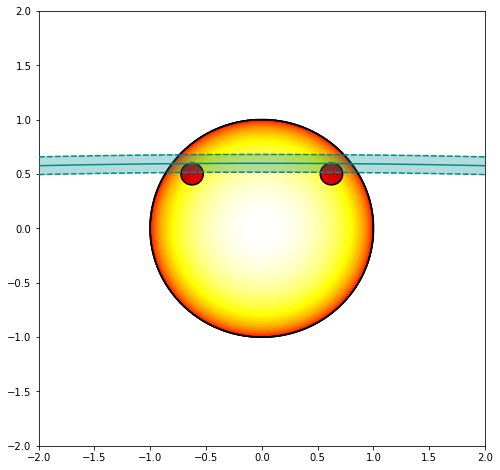

In [168]:
px=params[0]
py=-1.0*params[1]

sy=-1.0*sy

plt_lims=2

###### limb darkening ######
####################################################      
star_limb=quadraticlimbdarkening(r,c1,c2)

norm=matplotlib.colors.Normalize(vmin=np.min(star_limb),vmax=np.max(star_limb))                                                                                                                 
colors=matplotlib.cm.hot
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])


print '*calculating limb darkening*'
star_x=np.linspace(-1,1,1000)
star_y=np.linspace(-1,1,1000)
circle=np.empty([len(star_x),len(star_y)])
limb=np.empty([len(star_x),len(star_y)])
for j in range(0,len(star_x)):
    circle[j,:]=np.sqrt(star_x[j]**2.+star_y**2.)

for j in range(0,len(star_x)):
    for k in range(0,len(star_y)):
        rad=np.sqrt(star_x[j]**2.+star_y[k]**2.)
        if rad>1.0:
            limb[j,k]=np.nan
        if rad<=1.0:
            rad_ind=np.argmin(np.abs(r-rad))
            limb[j,k]=star_limb[rad_ind]    

print '*calculating spot*'
nspots=len(spotx)

spot_x=np.linspace(-1,1,1000)
spot_y=np.linspace(-1,1,1000)
spot_c=np.empty([nspots,len(spot_x),len(spot_y)])
spot_l=np.empty([nspots,len(spot_x),len(spot_y)])
for i in range(0,nspots):
    for j in range(0,len(spot_x)):
        for k in range(0,len(spot_y)):
            trad=np.sqrt((spot_x[j])**2.+(spot_y[k])**2.)
            if trad<1.0:
                spot_c[i,j,k]=np.sqrt((spot_x[j]-sx[i])**2.+(spot_y[k]-sy[i])**2.)
    
for i in range(0,nspots):
    for j in range(0,len(spot_x)):
        for k in range(0,len(spot_y)):
            rad=np.sqrt((spot_x[j]-sx[i])**2.+(spot_y[k]-sy[i])**2.)
            s_loc=np.sqrt(sx[i]**2.+sy[i]**2.)
            trad=np.sqrt((spot_x[j])**2.+(spot_y[k])**2.)
            if trad>1.0 or rad>sr[i]:
                spot_l[i,j,k]=np.nan
            if trad<=1.0 and rad<sr[i]:
                rad_ind=np.argmin(np.abs(r-trad))
                spot_l[i,j,k]=sc[i]*star_limb[rad_ind]
    

print '*plotting*'
limb_levels=np.linspace(0,1,100)

plt.figure(1,figsize=(8,8))
plt.contour(star_x,star_y,circle,levels=[1],colors='black',zorder=2)
plt.contourf(star_x,star_y,limb,levels=limb_levels,cmap=matplotlib.cm.hot,zorder=1)

for i in range(0,nspots):
    plt.contour(spot_x,spot_y,spot_c[i,:,:],levels=[sr[i]],colors='black',zorder=10)
    plt.contourf(spot_x,spot_y,spot_l[i,:,:],levels=limb_levels,cmap=matplotlib.cm.hot,zorder=9)


plt.plot(py,px,linestyle='-',color='darkcyan',zorder=18)
plt.plot(py,px+rp/2,linestyle='--',color='darkcyan',zorder=19)
plt.plot(py,px-rp/2,linestyle='--',color='darkcyan',zorder=20)

plt.fill_between(py,px-rp/2,px+rp/2,color='darkcyan',alpha=0.3,zorder=17)

plt.xlim(-plt_lims,plt_lims)
plt.ylim(-plt_lims,plt_lims)

In [17]:
output_file_path='/Users/ermay/Desktop/spot_stuff/'  #create a folder and put the name of it here

input_data_white=fit0_ar   #name of your array with full data here!
input_data_binns=fit_ar.T

input_time=time #name of your array with full time here!

bin_ctr=bins

nwalkers=500
burnin=500
nsteps=5000

norm=matplotlib.colors.Normalize(vmin=np.min(bins),vmax=np.max(bins))                                                                                                                 
colors=matplotlib.cm.Spectral_r
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

#####################################################                                                                                           
#####################################################                                                                                           
##        Fitting of lightcurves using BATMAN      ##                                                                                           
##  ---------------------------------------------  ##                                                                                           
##  reads in .npz files from Lightcurve_Script.py  ##                                                                                           
##     See README.txt in Magellan/pipeline         ##                                                                                           
#####################################################                                                                                           
#####################################################   

import numpy as np
np.seterr(all='ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import batman

import emcee
import corner

#import astropy
#from astropy.time import Time
#import pyfits                                                                                                                                  

import scipy
from scipy.interpolate import interp1d

from datetime import datetime
startTime1=datetime.now()

import sys
print (sys.argv)
 

#sys.path.insert(0,SAVEPATH) 
from SystemCons import *

print per, rp, sma

#width=200


#################################
t=input_time
n_exp=len(t)

lc_data_white=input_data_white
lc_data_binns=input_data_binns


####################################################                                                                                            
#              LIMB DARKENING FUNCION              #                                                                                            
####################################################                                                                                            
# U B V R I J H K                                                                                                                               

limb_dark='quadratic'

wave=[3640,4450,5510,6580,8060,12200]#,16300,21900]                                                                                             

q0_func=interp1d(wave,q0)
q1_func=interp1d(wave,q1)

####################################################                                                                                            
#              LIGHT CURVE FUNCTION                #                                                                                            
####################################################                                                                                            
def lc_func(t,t0,per,rp,a,inc,ecc,w,u,limb_dark):
    params=batman.TransitParams()
    params.t0=t0
    params.per=per
    params.rp=rp
    params.a=a
    params.inc=inc
    params.ecc=ecc
    params.w=w
    params.u=u
    params.limb_dark=limb_dark

    model=batman.TransitModel(params,t)
    return params, model

####################################################                                                                                            
#     Prior, Likelihood, Posterior Functions       #                                                                                            
####################################################                                                                                            
def loggaus(mean,sig,param):
    return -np.log(np.sqrt(2*np.pi*sig**2.))-((param-mean)**2.)/(2*sig**2.)

def lnprior(theta,color):
    if color==0:
        t0_f,per_f,rp_f,inc_f,c1_f,c2_f=theta
        if t0_f>t0dn and t0_f<t0up and rp_f>rpdn and rp_f<rpup and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return loggaus(per,per_e,per_f)+loggaus(inc,inc_e,inc_f)
        else:
            return -np.inf
    if color==1:
        rp_f,c1_f,c2_f=theta
        if rp_f<rpup and rp_f>rpdn and np.abs(c2_f-c2)<0.1 and np.abs((c2_f-c2)-(c1_f-c1))<0.05:
            return 0.0
        else:
            return -np.inf

def lnlike(theta,params,model,t,flux,err,color):
    if color==0:
        params.t0,params.per,params.rp,params.inc,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        Ms_s=np.random.normal(loc=Ms,scale=Ms_e)
        Rs_s=np.random.normal(loc=Rs,scale=Rs_e)
        smacm=(((params.per*24.*60.*60.)**2.*Grav*Ms_s)/(4*np.pi**2.))**(1./3.)
        params.a=smacm/Rs_s
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))
    if color==1:
        params.rp,c1_f,c2_f=theta
        params.u=[c1_f,c2_f]
        fit=model.light_curve(params)
        residuals=flux-fit
        return -0.5*(np.nansum((residuals/err)**2))


def lnprob(theta,params,model,t,flux,err,color):
    prior=lnprior(theta,color)
    if not np.isfinite(prior):
        return -np.inf
    post=prior+lnlike(theta,params,model,t,flux,err,color)
    return post

####################################################                                                                                            
#     RUN MCMC CODE      #                                                                                            
####################################################   

def runmcmc(nwalkers,burnin,nsteps,pos0,params,model,time,data,error,color):
    sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2.0, args=(params,m,t,data,error,color))
    
    Output=open(output_file_path+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Running Burn-in...'))
                                                                                                                        
    time1=datetime.now()
    p0,test1,test2=sampler.run_mcmc(pos0,burnin)
    time2=datetime.now()
    Output.write('{0} {1} \n'.format('           Time to Run: ', time2-time1))
    sampler.reset()
                                                                                                                          

    Output.write('{0} \n'.format('     -->> Running Chain...'))
    Output.close()
    for i, result in enumerate(sampler.sample(p0,iterations=nsteps)):
        if (i+1)%(nsteps/10) ==0:
            Output=open(output_file_path+'/Progress.txt','a')
            Output.write('{0} {1} {2} \n'.format(("            {0:5.1%}".format(float(i+1) / nsteps)),'          ', datetime.now()))
            Output.close()

    Output=open(output_file_path+'/Progress.txt','a')
    Output.write('{0} {1} \n'.format('     -->> Mean Acceptance Fraction: ', np.mean(sampler.acceptance_fraction)))
    Output.close()
    
    samples=sampler.chain[:,:,:].reshape((-1,pos0.shape[1]))
    
    return samples

    

#####################
#nwalkers=500
#burnin=500
#nsteps=3000

Output=open(output_file_path+'/Progress.txt','w')

color=1
if color==0:
    Output=open(output_file_path+'/Progress.txt','a')
    Output.write('{0}\n'.format('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<'))
    Output.write('{0} {1} {2} {3}\n'.format(spotx,spoty,spotradius,spotcontrast))
    print('>>>>>>>>>> WHITE LIGHT CURVE <<<<<<<<<<')
    
    yerr=10**-3
    
    c1=q0_func(6000)
    c2=q1_func(6000)
    u=[c1,c2]
                                                                                                                          
    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
    initial=np.array([t0,per,rp,inc,c1,c2])
    ndim=len(initial)
    
    Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
    Output.close()

    t0_arr=np.linspace(t0dn,t0up,10**6.)
    per_arr=np.linspace(per-5*per_e,per+5*per_e,10**6.)
    rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
    inc_arr=np.linspace(inc-5*inc_e,inc+5*inc_e,10**6.)
    c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
    c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

    pos0=np.empty([nwalkers,ndim])
    for i in range(nwalkers):
        pos0[i,:]=np.array([np.random.choice(t0_arr),np.random.choice(per_arr),np.random.choice(rp_arr),np.random.choice(inc_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
    runwhite=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_white,yerr,color)
    
    t0o,pero,rpo,inco,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runwhite, [16, 50, 84], axis=0)))
    t0,per,rp,inc,c1,c2=t0o[0],pero[0],rpo[0],inco[0],c1o[0],c2o[0]
    u=[c1,c2]
    sma=(((per*24.*60.*60.)**2.*Grav*Ms)/(4*np.pi**2.))**(1./3.)
    sma=sma/Rs

    params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
    fitlightcurve=m.light_curve(params)
    
    residuals=(fitlightcurve-lc_data_white)*10**6.
    res_white=residuals
    chi2=np.nansum(np.abs(residuals/10**6.)**2.)

    Output=open(output_file_path+'/Progress.txt','a')
    Output.write('{0} \n'.format('     -->> Best Fit Params'))
    Output.write('{0} {1} {2} {3} \n'.format('          t0  : ', t0,  np.round(t0o[1],5),np.round(t0o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          per : ', per, np.round(pero[1],10),np.round(pero[2],10)))
    Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
    Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
    Output.write('{0} {1} {2} {3} \n'.format('          inc : ', inc, np.round(inco[1],5),np.round(inco[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
    Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
    Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
    Output.close()

    plt.figure()
#    plt.clf()                                                                                                                                  
    plt.plot(t,lc_data_white,'.',markersize=10,markeredgecolor='black',markerfacecolor='grey')
    plt.plot(t,fitlightcurve,'-',color='black')
    plt.ylim(0.96,1.01)
    plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
#    plt.figtext(0.55,0.60, str(int(bin_wav[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_wav[b]))                                         
    plt.figtext(0.55,0.80, 'White Light', fontsize=25,color='grey')
    plt.savefig(output_file_path+'/Fit_Orbit_LC_white.png')
    plt.close()

    t0min=np.max([t0dn,t0-5*t0o[2]])
    t0max=np.min([t0up,t0+5*t0o[1]])
    rpmin=np.max([rpdn,rp-5*rpo[2]])
    rpmax=np.min([rpup,rp+5*rpo[1]])
    
    plt.clf()
    corner.corner(runwhite,labels=['t0','per','rp','inc','c1','c2'],truths=[t0,per,rp,inc,c1,c2],range=([t0min,t0max],[per-5*pero[2],per+5*pero[1]],[rpmin,rpmax],[inc-5*inco[2],inc+5*inco[1]],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
    plt.savefig(output_file_path+'/CornerPlot_white.png')
    plt.close()

    Output=open(output_file_path+'/Progress.txt','a')
    Output.write('{0}\n'.format(' '))
    Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
    Output.write('{0}\n'.format(' '))

    
    Output.write('{0}\n'.format(' '))
    Output.write('{0} \n'.format('***ACTUAL LIMB DARKENING***'))
    Output.write('{0} {1}\n'.format(q0_func(6000),q1_func(6000)))
    Output.write('{0} \n'.format('*** FIT LIMB DARKENING  ***'))
    Output.write('{0} {1}\n'.format(params.u[0],params.u[1]))
    Output.write('{0}\n'.format(' '))
    Output.close()

    params=np.array([params.t0,params.per,params.rp,params.a,params.inc,params.u[0],params.u[1]])
    paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])

    np.savez_compressed(output_file_path+'/LightCurve_fits_white.npz',results=runwhite,params=params,paramserr=paramserr,lightcurve_fit=fitlightcurve,residuals=residuals)

color=1

if color==1:
    for b in range(0,len(bin_ctr)):
        Output=open(output_file_path+'/Progress.txt','a')
        Output.write('{0} {1} {2}\n'.format('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<'))
        Output.write('{0} {1} {2} {3}\n'.format(spotx,spoty,spotradius,spotcontrast[:,b]))
        print('>>>>>>>>>> WAVELENGTH BIN: ' ,bin_ctr[b], ' <<<<<<<<<<')
        if np.isnan(lc_data_binns[0,b]):
            continue
        #lc_data_binns[:,b]=lc_data_binns[:,b]+res_white*10**-6
#        Output.write('{0} {1} \n'.format(' -->> WAVLENGTH CENTER = ', bin_ctr[b]))
    
        yerr_binns=10**-3
        #if np.nanmax(yerr_binns[:,b])==0.0:
        #    hold=np.ones_like(yerr_binns[:,b])*10**-3.
        #    yerr_binns[:,b]=hold
    
        c1=q0_func(bin_ctr[b])
        c2=q1_func(bin_ctr[b])
        u=[c1,c2]
                                                                                                                          
        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
    
        initial=np.array([rp,c1,c2])
        ndim=len(initial)
    
        Output.write('{0} {1} \n'.format('     -->> Initial Guess: ', initial))
        Output.close()

        rp_arr=np.linspace(rpdn,rpup,10**6.)                                                                                              
        c1_arr=np.linspace(c1-0.2,c1+0.2,10**6.)
        c2_arr=np.linspace(c2-0.2,c2+0.2,10**6.)  

        pos0=np.empty([nwalkers,ndim])
        for i in range(nwalkers):
            pos0[i,:]=np.array([np.random.choice(rp_arr),np.random.choice(c1_arr),np.random.choice(c2_arr)])
        
        runlam=runmcmc(nwalkers,burnin,nsteps,pos0,params,m,t,lc_data_binns[:,b],yerr_binns,color)
    
        rpo,c1o,c2o=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(runlam, [16, 50, 84], axis=0)))
        rp,c1,c2=rpo[0],c1o[0],c2o[0]
        u=[c1,c2]

        params,m=lc_func(t,t0,per,rp,sma,inc,ecc,w,u,limb_dark)
        
        fitlightcurve=m.light_curve(params)
        
        residuals=(fitlightcurve-lc_data_binns[:,b])*10**6.
        chi2=np.nansum(np.abs(residuals/10**6.)**2.)

        Output=open(output_file_path+'/Progress.txt','a')
        Output.write('{0} \n'.format('     -->> Best Fit Params'))
        Output.write('{0} {1} \n'.format('          t0  : ', t0))#,  np.round(t0o[1],5),np.round(t0o[2],5)))                                        
        Output.write('{0} {1} \n'.format('          per : ', per))#, np.round(pero[1],5),np.round(pero[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          rp  : ', rp,  np.round(rpo[1],5),np.round(rpo[2],5)))
        Output.write('{0} {1} \n'.format('          a   : ', sma))#, np.round(smao[1],5),np.round(smao[2],5)))                                      
        Output.write('{0} {1} \n'.format('          inc : ', inc))#, np.round(inco[1],5),np.round(inco[2],5)))                                      
        Output.write('{0} {1} {2} {3} \n'.format('          c1  : ', c1,  np.round(c1o[1],5),np.round(c1o[2],5)))
        Output.write('{0} {1} {2} {3} \n'.format('          c2  : ', c2,  np.round(c2o[1],5),np.round(c2o[2],5)))
        Output.write('{0} {1} \n'.format('  chi-squared : ', chi2))
        Output.close()

        plt.figure()
#    plt.clf()                                                                                                                                  
        plt.plot(t,lc_data_binns[:,b],'.',markersize=10,markeredgecolor='black',markerfacecolor=scal_m.to_rgba(bin_ctr[b]))
        plt.plot(t,fitlightcurve,'-',color='black')
        plt.ylim(0.96,1.01)
        plt.figtext(0.15,0.15,'$\chi^2$ = '+str(chi2))
        plt.figtext(0.55,0.80, str(int(bin_ctr[b]))+' $\AA$',fontsize=25,color=scal_m.to_rgba(bin_ctr[b]))                                         
#        plt.figtext(0.55,0.60, 'White Light', fontsize=25,color='grey')
        plt.savefig(output_file_path+'/Fit_Orbit_LC_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        rpmin=np.max([rpdn,rp-5*rpo[2]])
        rpmax=np.min([rpup,rp+5*rpo[1]])
    
        plt.clf()
        corner.corner(runlam,labels=['rp','c1','c2'],truths=[rp,c1,c2],range=([rpmin,rpmax],[c1-5*c1o[2],c1+5*c1o[1]],[c2-5*c2o[2],c2+5*c2o[1]]))
        plt.savefig(output_file_path+'/CornerPlot_'+str(int(bin_ctr[b]))+'.png')
        plt.close()

        Output=open(output_file_path+'/Progress.txt','a')
        Output.write('{0}\n'.format(' '))
        Output.write('{0} {1} \n'.format('            TIME TO RUN: ', datetime.now() - startTime1))
        Output.write('{0}\n'.format(' '))
        
        Output.write('{0}\n'.format(' '))
        Output.write('{0} \n'.format('***ACTUAL LIMB DARKENING***'))
        Output.write('{0} {1}\n'.format(q0_func(bin_ctr[b]),q1_func(bin_ctr[b])))
        Output.write('{0} \n'.format('*** FIT LIMB DARKENING  ***'))
        Output.write('{0} {1}\n'.format(params.u[0],params.u[1]))
        Output.close()
        
        Output.close()

        params=np.array([params.rp,params.u[0],params.u[1]])
        #paramserr=np.array([[t0o[1],t0o[2]],[pero[1],pero[2]],[rpo[1],rpo[2]],[inco[1],inco[2]]])
        
        

        np.savez_compressed(output_file_path+'/LightCurve_fits_'+str(int(bin_ctr[b]))+'.npz',results=runlam,params=params,lightcurve_fit=fitlightcurve,residuals=residuals)    

['/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/ermay/Library/Jupyter/runtime/kernel-6eeee65f-696a-4fd3-8d23-d7dc76c8cd69.json']
1.7497798 0.15 7.38338832319
('>>>>>>>>>> WAVELENGTH BIN: ', 4000.0, ' <<<<<<<<<<')


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:318: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:319: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:320: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


('>>>>>>>>>> WAVELENGTH BIN: ', 4200.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 4400.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 4600.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 4800.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5000.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5200.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5400.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5600.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 5800.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6000.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6200.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6400.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6600.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 6800.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 7000.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 7200.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 7400.0, ' <<<<<<<<<<')
('>>>>>>>>>> WAVELENGTH BIN: ', 7600.0, ' <<<<<<<<<<')
('>>>>>>>>

In [145]:
print '***ACTUAL LIMB DARKENING***'
print q0_func(6000),q1_func(6000)
print '*** FIT LIMB DARKENING  ***'
print c1,c2

***ACTUAL LIMB DARKENING***
0.594358878505 0.148210280374
*** FIT LIMB DARKENING  ***
0.652890348518 0.207007984811


In [13]:
print spotcontrast.shape

(2, 21)


In [5]:
c1_ac=q0_func(bins)
c2_ac=q1_func(bins)

c1_ft=np.zeros_like(c1_ac)
c2_ft=np.zeros_like(c2_ac)

read_path='/Users/ermay/Desktop/spot_stuff/'

for b in range(0,len(c1_ft)):
    t=np.load(read_path+'LightCurve_fits_'+str(int(bins[b]))+'.npz')['params']
    c1_ft[b]=t[1]
    c2_ft[b]=t[2]

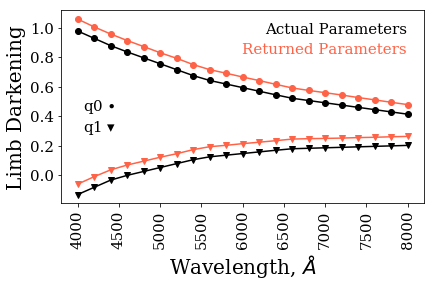

In [53]:
ft_c='tomato'

from matplotlib.font_manager import FontProperties
font0=FontProperties()
font=font0.copy()
font.set_family('serif')

fontb=font.copy()
fontb.set_weight('bold')

plt.gcf().subplots_adjust(bottom=0.28,top=0.95,left=0.15,right=0.99)

plt.plot(bins,c1_ac,color='black')
plt.plot(bins,c1_ft,color=ft_c)
plt.plot(bins,c1_ac,'o',color='black')
plt.plot(bins,c1_ft,'o',color=ft_c)

plt.plot(bins,c2_ac,color='black')
plt.plot(bins,c2_ft,color=ft_c)
plt.plot(bins,c2_ac,'v',color='black')
plt.plot(bins,c2_ft,'v',color=ft_c)

plt.figtext(0.95,0.87,'Actual Parameters',color='black',fontsize=15,ha='right',fontproperties=font)
plt.figtext(0.95,0.80,'Returned Parameters',color=ft_c,fontsize=15,ha='right',fontproperties=font)
plt.figtext(0.2,0.6,'q0 $\\bullet$',color='black',fontsize=15,fontproperties=font)
plt.figtext(0.2,0.53,'q1 $\\blacktriangledown$',color='black',fontsize=15,fontproperties=font)

plt.xticks(fontproperties=font,fontsize=15,rotation='vertical')
plt.yticks(fontproperties=font,fontsize=15)

plt.xlabel('Wavelength, $\AA$',fontproperties=font,fontsize=20)
plt.ylabel('Limb Darkening',fontproperties=font,fontsize=20)

plt.savefig(output_file_path+'spot_effect.eps')


*calculating limb darkening* -- 18
*calculating spot* -- 18
*plotting*


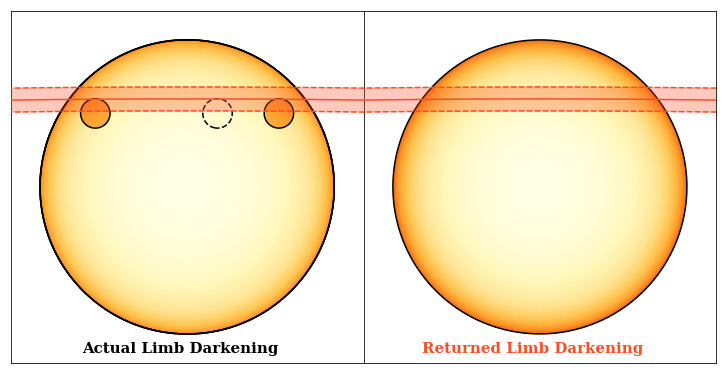

In [8]:
#### PLOTS FOR EACH LAMBA

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

norm=matplotlib.colors.Normalize(vmin=np.min(bins),vmax=np.max(bins))                                                                                                                 
colors=matplotlib.cm.rainbow
scal_m=matplotlib.cm.ScalarMappable(cmap=colors,norm=norm)
scal_m.set_array([])

px=params[0]
py=-1.0*params[1]

sy=-1.0*sy
plt_lims=1.2

star_x=np.linspace(-1,1,1000)
star_y=np.linspace(-1,1,1000)
circle=np.empty([len(star_x),len(star_y)])
limb=np.empty([len(star_x),len(star_y)])
limb_fit=np.empty([len(star_x),len(star_y)])

output_file_path='/Users/ermay/Desktop/spot_stuff/plots/'

from matplotlib.font_manager import FontProperties
font0=FontProperties()
font=font0.copy()
font.set_family('serif')

fontb=font.copy()
fontb.set_weight('bold')

asx=sx[0]
asy=0.207

###### limb darkening ######
####################################################      

for b in range(18,19):#len(bins)):
    star_limb=quadraticlimbdarkening(r,c1_ac[b],c2_ac[b])
    fitt_limb=quadraticlimbdarkening(r,c1_ft[b],c2_ft[b])

    print '*calculating limb darkening* --', b

    for j in range(0,len(star_x)):
        circle[j,:]=np.sqrt(star_x[j]**2.+star_y**2.)

    for j in range(0,len(star_x)):
        for k in range(0,len(star_y)):
            rad=np.sqrt(star_x[j]**2.+star_y[k]**2.)
            if rad>1.0:
                limb[j,k]=np.nan
                limb_fit[j,k]=np.nan
            if rad<=1.0:
                rad_ind=np.argmin(np.abs(r-rad))
                limb[j,k]=star_limb[rad_ind]  
                limb_fit[j,k]=fitt_limb[rad_ind]
    
    print '*calculating spot* --', b
    nspots=len(spotx)

    spot_x=np.linspace(-1,1,1000)
    spot_y=np.linspace(-1,1,1000)
    spot_c=np.empty([nspots,len(spot_x),len(spot_y)])
    spot_l=np.empty([nspots,len(spot_x),len(spot_y)])
    
    spot_a=np.empty([len(spot_x),len(spot_y)])
    for i in range(0,nspots):
        for j in range(0,len(spot_x)):
            for k in range(0,len(spot_y)):
                trad=np.sqrt((spot_x[j])**2.+(spot_y[k])**2.)
                if trad<1.0:
                    spot_c[i,j,k]=np.sqrt((spot_x[j]-sx[i])**2.+(spot_y[k]-sy[i])**2.)
                    
    for j in range(0,len(spot_x)):
        for k in range(0,len(spot_y)):
            trad=np.sqrt((spot_x[j])**2.+(spot_y[k])**2.)
            if trad<1.0:
                spot_a[j,k]=np.sqrt((spot_x[j]-asx)**2.+(spot_y[k]-asy)**2.)
    
    for i in range(0,nspots):
        for j in range(0,len(spot_x)):
            for k in range(0,len(spot_y)):
                rad=np.sqrt((spot_x[j]-sx[i])**2.+(spot_y[k]-sy[i])**2.)
                s_loc=np.sqrt(sx[i]**2.+sy[i]**2.)
                trad=np.sqrt((spot_x[j])**2.+(spot_y[k])**2.)
                if trad>1.0 or rad>sr[i]:
                    spot_l[i,j,k]=np.nan
                if trad<=1.0 and rad<sr[i]:
                    rad_ind=np.argmin(np.abs(r-trad))
                    spot_l[i,j,k]=spotcontrast[i,b]*star_limb[rad_ind]
                    
    print '*plotting*'
    limb_levels=np.linspace(0,np.nanmax(star_limb),100)

    fig,ax=plt.subplots(1,2,figsize=(10,5))
    plt.gcf().subplots_adjust(bottom=0.01,top=0.99,left=0.01,right=0.99)
    
    ax[0].contour(star_x,star_y,circle,levels=[1],colors='black',zorder=2)
    ax[0].contourf(star_x,star_y,limb,levels=limb_levels,cmap=matplotlib.cm.YlOrBr_r,zorder=1)

    for i in range(0,nspots):
        ax[0].contour(spot_x,spot_y,spot_c[i,:,:],levels=[sr[i]],colors='black',zorder=10)
        ax[0].contourf(spot_x,spot_y,spot_l[i,:,:],levels=limb_levels,cmap=matplotlib.cm.YlOrBr_r,zorder=9)

    ax[0].contour(spot_x,spot_y,spot_a,levels=[sr[0]],colors='black',linestyles='--',zorder=10)

    ax[0].plot(py,px,linestyle='-',color=scal_m.to_rgba(bins[b]),zorder=18)
    ax[0].plot(py,px+rp/2,linestyle='--',color=scal_m.to_rgba(bins[b]),zorder=19)
    ax[0].plot(py,px-rp/2,linestyle='--',color=scal_m.to_rgba(bins[b]),zorder=20)

    ax[0].fill_between(py,px-rp/2,px+rp/2,color=scal_m.to_rgba(bins[b]),alpha=0.3,zorder=17)
    
    ax[0].set_xlim(-plt_lims,plt_lims)
    ax[0].set_ylim(-plt_lims,plt_lims)
    
    #ax[0].set_title('BIN: '+str(int(bins[b])))

    ax[0].set_xticks([],[])
    ax[0].set_yticks([],[])
    
    ax[1].contour(star_x,star_y,circle,levels=[1],colors='black',zorder=2)
    ax[1].contourf(star_x,star_y,limb_fit,levels=limb_levels,cmap=matplotlib.cm.YlOrBr_r,zorder=1)
    
    ax[1].plot(py,px,linestyle='-',color=scal_m.to_rgba(bins[b]),zorder=18)
    ax[1].plot(py,px+rp/2,linestyle='--',color=scal_m.to_rgba(bins[b]),zorder=19)
    ax[1].plot(py,px-rp/2,linestyle='--',color=scal_m.to_rgba(bins[b]),zorder=20)

    ax[1].fill_between(py,px-rp/2,px+rp/2,color=scal_m.to_rgba(bins[b]),alpha=0.3,zorder=17)
    
    ax[1].set_xlim(-plt_lims,plt_lims)
    ax[1].set_ylim(-plt_lims,plt_lims)
    
    #ax[0].set_title('BIN: '+str(int(bins[b])))

    ax[1].set_xticks([],[])
    ax[1].set_yticks([],[])
    
    fig.subplots_adjust(hspace=0,wspace=0)
    
    plt.figtext(0.245,0.04,'Actual Limb Darkening',color='black',fontsize=15,fontproperties=fontb,ha='center')
    plt.figtext(0.735,0.04,'Returned Limb Darkening',color=scal_m.to_rgba(bins[b]),fontsize=15,fontproperties=fontb,ha='center')
    
    #plt.show()
    plt.savefig(output_file_path+'DARKENING_PAPER.pdf')